## Exploratory Data Analysis

In [132]:
import pandas as pd
import numpy as np
import calendar
import folium
from branca.element import Template, MacroElement

In [3]:
ridership_data = pd.read_csv('data/final_ridership.csv')

In [4]:
ridership_data.head()

,station_id,map_id,station_descriptive_name,ride_date,day_type,rides,ada_approved,red,blue,green,brownn,purple,pexp,yellow,pnk,orange,location
0,41090,41090,Monroe (Red Line),2024-07-27,A,2961,f,t,f,f,f,f,f,f,f,f,"(41.880745, -87.627696)"
1,41090,41090,Monroe (Red Line),2024-07-31,W,5017,f,t,f,f,f,f,f,f,f,f,"(41.880745, -87.627696)"
2,41120,41120,35th-Bronzeville-IIT (Green Line),2024-07-27,A,643,t,f,f,t,f,f,f,f,f,f,"(41.831677, -87.625826)"
3,41120,41120,35th-Bronzeville-IIT (Green Line),2024-07-31,W,980,t,f,f,t,f,f,f,f,f,f,"(41.831677, -87.625826)"
4,41130,41130,Halsted (Orange Line),2024-07-07,U,799,t,f,f,f,f,f,f,f,f,t,"(41.84678, -87.648088)"


In [5]:
ridership_data['ride_date'] = pd.to_datetime(ridership_data['ride_date'])

In [6]:
ridership_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251166 entries, 0 to 1251165
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   station_id                1251166 non-null  int64         
 1   map_id                    1251166 non-null  int64         
 2   station_descriptive_name  1251166 non-null  object        
 3   ride_date                 1251166 non-null  datetime64[ns]
 4   day_type                  1251166 non-null  object        
 5   rides                     1251166 non-null  int64         
 6   ada_approved              1251166 non-null  object        
 7   red                       1251166 non-null  object        
 8   blue                      1251166 non-null  object        
 9   green                     1251166 non-null  object        
 10  brownn                    1251166 non-null  object        
 11  purple                    1251166 non-null  object

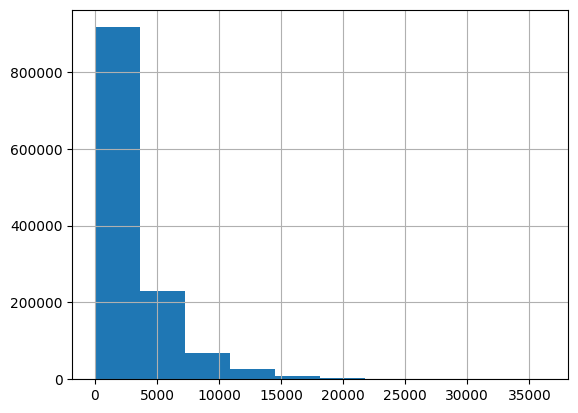

In [7]:
ridership_data['rides'].hist();

## Questions
How has ridership changed over time? Has it recovered to pre-COVID levels?

Which lines and stations are the busiest? And the least busy?

Which lines are the most ADA accessible? (Measured by the number of ADA-accessible stations per line)

# How has ridership changed over time?

In [8]:
# how has ridership changed over time?
# ridership averages by month pre-COVID vs ridership averages by month Post-COVID

# Steps: 
# 1. separate into 2 groups: Pre-covid and Post-covid
# 2. Within each group, organize by month
# 3. Find the average for each month

# pre-covid: Pre-March 2020
# post-covid: Post-May 2023

In [9]:
# Extract year and month from ride_date
ridership_data['year'] = ridership_data['ride_date'].dt.year
ridership_data['month'] = ridership_data['ride_date'].dt.month

In [114]:
yearly_ridership = ridership_data.groupby('year')['rides'].sum().astype(int)

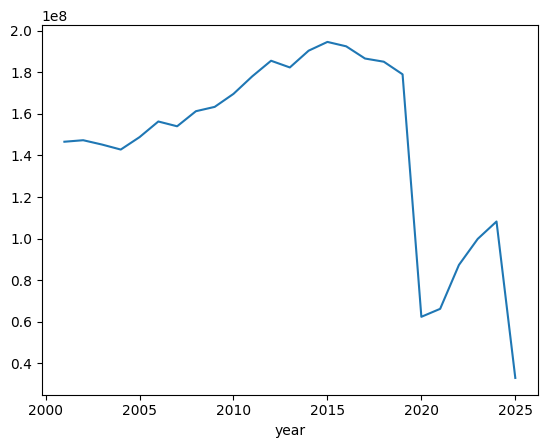

In [115]:
yearly_ridership.plot.line();

## Has Ridership Recovered to Pre-COVID Levels?

In [23]:
# creates slices of ridership_data representing pre- and post-covid
pre_covid = ridership_data[
    (ridership_data['year'] < 2020) |
    ((ridership_data['year'] == 2020) & (ridership_data['month'] < 3))
]

post_covid = ridership_data[
    (ridership_data['year'] > 2023) |
    ((ridership_data['year'] == 2023) & (ridership_data['month'] > 5))
]

In [32]:
datasets = [pre_covid, post_covid]

def calculate_monthly_avg_ridership(pre_df, post_df):
    
    """
    Calculates the average total monthly ridership for pre- and post-COVID datasets.

    Parameters:
    -----------
    pre_df : pandas.DataFrame
        DataFrame containing pre-COVID ridership data. Must include a 'ride_date' column (datetime type) and 'rides'.
    post_df : pandas.DataFrame
        DataFrame containing post-COVID ridership data. Same structure as pre_df.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame indexed by month name (January–December), with two columns:
        - 'avg_pre_covid_rides': average total ridership per month (pre-COVID)
        - 'avg_post_covid_rides': average total ridership per month (post-COVID)
    """
    
    def process(df):
        df = df.copy()
        df['month_year'] = df['ride_date'].dt.to_period('M')
        monthly_totals = df.groupby('month_year')['rides'].sum().reset_index()
        monthly_totals['month'] = monthly_totals['month_year'].dt.month
        avg_by_month = monthly_totals.groupby('month')['rides'].mean().round(0).astype(int)
        return avg_by_month

    pre_avg = process(pre_df)
    post_avg = process(post_df)

    comparison = pd.concat([pre_avg, post_avg], axis=1)
    comparison.columns = ['avg_pre_covid_rides', 'avg_post_covid_rides']
    comparison.index = comparison.index.map(lambda x: calendar.month_name[x])  # replace index with month names
    comparison.index.name = 'month'

    return comparison

In [33]:
avg_ridership_comparison = calculate_monthly_avg_ridership(pre_covid, post_covid)
avg_ridership_comparison

,avg_pre_covid_rides,avg_post_covid_rides
month,,
January,12959114,7424130
February,12629832,7576030
March,14108834,8686651
April,13945851,9083476
May,14330408,9585547
June,14523167,9026587
July,14698472,9016599
August,14784369,9722895
September,14872444,9679792


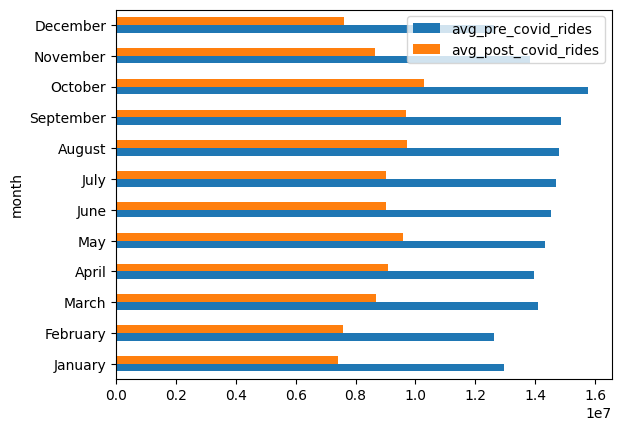

In [36]:
avg_ridership_comparison.plot.barh();

In [45]:
# what % of pre-covid ridership levels is CTA at?
(avg_ridership_comparison['avg_post_covid_rides'].sum() / avg_ridership_comparison['avg_pre_covid_rides'].sum()).round(2) * 100

63.0

## Which Stations are the Most and Least busy

In [116]:
post_covid.head() 

,station_id,map_id,station_descriptive_name,ride_date,day_type,rides,ada_approved,red,blue,green,brownn,purple,pexp,yellow,pnk,orange,location,year,month
0,41090,41090,Monroe (Red Line),2024-07-27,A,2961,f,t,f,f,f,f,f,f,f,f,"(41.880745, -87.627696)",2024,7
1,41090,41090,Monroe (Red Line),2024-07-31,W,5017,f,t,f,f,f,f,f,f,f,f,"(41.880745, -87.627696)",2024,7
2,41120,41120,35th-Bronzeville-IIT (Green Line),2024-07-27,A,643,t,f,f,t,f,f,f,f,f,f,"(41.831677, -87.625826)",2024,7
3,41120,41120,35th-Bronzeville-IIT (Green Line),2024-07-31,W,980,t,f,f,t,f,f,f,f,f,f,"(41.831677, -87.625826)",2024,7
4,41130,41130,Halsted (Orange Line),2024-07-07,U,799,t,f,f,f,f,f,f,f,f,t,"(41.84678, -87.648088)",2024,7


In [131]:
station_ridership = post_covid.groupby('station_descriptive_name')['rides'].sum().reset_index().sort_values('rides', ascending = False)
station_ridership = station_ridership.rename(columns={'rides': 'total_rides'})
station_ridership

,station_descriptive_name,total_rides
93,Lake (Red Line),6358194
110,O'Hare (Blue Line),5791109
43,"Clark/Lake (Blue, Brown, Green, Orange, Purple...",5263110
131,"State/Lake (Brown, Green, Orange, Pink & Purpl...",4820881
38,Chicago (Red Line),4737646
...,...,...
67,Halsted (Green Line),181999
90,Kostner (Pink Line),180235
89,King Drive (Green Line),161408
26,Berwyn (Red Line),0


In [141]:
# Define your color scheme for each line
line_colors = {
    'red': 'red',
    'blue': 'blue',
    'green': 'green',
    'brown': 'saddlebrown',
    'purple': 'purple',
    'purple_express': 'purple',
    'yellow': 'yellow',
    'pink': 'deeppink',
    'orange': 'orange'
}
line_columns = list(line_colors.keys())

# Clean station name casing and merge with station data
deduped_stations['station_descriptive_name'] = deduped_stations['station_descriptive_name'].str.lower()
station_ridership['station_descriptive_name'] = station_ridership['station_descriptive_name'].str.lower()
station_map_data = pd.merge(deduped_stations, station_ridership, on='station_descriptive_name', how='inner')

# Assign line color logic
def assign_line_color(row):
    lines_served = [line for line in line_columns if row.get(line) == 1]
    if set(lines_served).issubset({'purple', 'purple_express'}):
        return 'purple'
    if len(lines_served) == 1:
        return line_colors[lines_served[0]]
    return 'grey'  # multi-line stations

station_map_data['dot_color'] = station_map_data.apply(assign_line_color, axis=1)

# Normalize ride volume for radius size
max_rides = station_map_data['total_rides'].max()
station_map_data['radius'] = station_map_data['total_rides'].apply(lambda x: 0.5 + (x / max_rides) * 10)

# Create the folium map
station_ridership_map = folium.Map(location=[41.8781, -87.6298], zoom_start=11, tiles='Cartodb dark_matter')

for _, row in station_map_data.iterrows():
    try:
        lat, lon = map(float, row['location'].strip('()').split(','))
        lines = [line for line in line_columns if row.get(line) == 1]
        popup_text = f"{row['station_name']}<br>Lines: {', '.join(lines).title()}<br>Total Rides: {int(row['total_rides']):,}"

        folium.CircleMarker(
            location=(lat, lon),
            radius=row['radius'],
            color=row['dot_color'],
            fill=True,
            fill_color=row['dot_color'],
            fill_opacity=0.8,
            popup=popup_text
        ).add_to(station_ridership_map)
    except:
        continue

# Add custom legend with title
legend_html = """
{% macro html(this, kwargs) %}
<div style="position: fixed; 
            top: 20px; right: 20px; width: 270px; z-index: 9999; font-size: 14px;
            background-color: white; padding: 10px; border:2px solid grey; border-radius: 6px;">
    <strong>Total CTA Station Ridership Since May 2023</strong><br><br>
    <u>Line Colors</u><br>
    <i style="background:red;color:red">....</i> Red&nbsp;&nbsp;
    <i style="background:blue;color:blue">....</i> Blue&nbsp;&nbsp;
    <i style="background:green;color:green">....</i> Green<br>
    <i style="background:saddlebrown;color:saddlebrown">....</i> Brown&nbsp;&nbsp;
    <i style="background:purple;color:purple">....</i> Purple&nbsp;&nbsp;
    <i style="background:yellow;color:yellow">....</i> Yellow<br>
    <i style="background:deeppink;color:deeppink">....</i> Pink&nbsp;&nbsp;
    <i style="background:orange;color:orange">....</i> Orange&nbsp;&nbsp;
    <i style="background:grey;color:grey">....</i> Multi-line<br><br>
    <u>Dot Size (approximate ridership)</u><br>
    <span style="display:inline-block;width:8px;height:8px;border-radius:50%;background:black;"></span> Low<br>
    <span style="display:inline-block;width:12px;height:12px;border-radius:50%;background:black;"></span> Moderate<br>
    <span style="display:inline-block;width:16px;height:16px;border-radius:50%;background:black;"></span> High
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
station_ridership_map.get_root().add_child(legend)

# Display the map
station_ridership_map

# Lines in need of more ADA accessibility

In [75]:
stations_data = pd.read_csv('data/CTA_-_System_Information_-_List_of__L__Stops_20250718.csv')
stations_data.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30082,E,Cicero (Loop-bound),Cicero,Cicero (Pink Line),40420,True,False,False,False,False,False,False,False,True,False,"(41.85182, -87.745336)"
1,30151,E,Central Park (Loop-bound),Central Park,Central Park (Pink Line),40780,True,False,False,False,False,False,False,False,True,False,"(41.853839, -87.714842)"
2,30184,W,Halsted/63rd (Ashland-bound),Halsted,Halsted (Green Line),40940,True,False,False,True,False,False,False,False,False,False,"(41.778943, -87.644244)"
3,30044,N,Cumberland (O'Hare-bound),Cumberland,Cumberland (Blue Line),40230,True,False,True,False,False,False,False,False,False,False,"(41.984246, -87.838028)"
4,30092,E,Racine (O'Hare-bound),Racine,Racine (Blue Line),40470,False,False,True,False,False,False,False,False,False,False,"(41.87592, -87.659458)"


In [76]:
# Lowercase all column names
stations_data.columns = stations_data.columns.str.lower()

# Rename line columns from abbreviations to full names
stations_data = stations_data.rename(columns={
    'red': 'red',
    'blue': 'blue',
    'g': 'green',
    'brn': 'brown',
    'p': 'purple',
    'pexp': 'purple_express',
    'y': 'yellow',
    'pnk': 'pink',
    'o': 'orange'
})

In [77]:
# Deduplicate by map_id to ensure each station is counted once
deduped_stations = stations_data.drop_duplicates(subset='map_id').copy()

# Define the actual line columns
line_columns = ['red', 'blue', 'green', 'brown', 'purple', 'purple_express', 'yellow', 'pink', 'orange']

#Reshape the data so each row is (station, line)
line_accessibility = deduped_stations.melt(
    id_vars=['map_id', 'ada'],
    value_vars=line_columns,
    var_name='line',
    value_name='serves_line'
)

# Keep only rows where the station serves the line
line_accessibility = line_accessibility[line_accessibility['serves_line'] == True]

In [78]:
# Group by line to count total and ADA-accessible stations
ada_summary = line_accessibility.groupby('line').agg(
    total_stations=('map_id', 'count'),
    ada_accessible=('ada', 'sum')
).reset_index()

# Calculate percentage
ada_summary['percent_ada_accessible'] = (
    ada_summary['ada_accessible'] / ada_summary['total_stations'] * 100
).round(1)

# Sort by percentage
ada_summary = ada_summary.sort_values(by='percent_ada_accessible', ascending=False)

# Display the result
ada_summary

,line,total_stations,ada_accessible,percent_ada_accessible
8,yellow,2,2,100.0
4,pink,17,16,94.1
1,brown,22,20,90.9
3,orange,10,9,90.0
2,green,29,24,82.8
7,red,30,20,66.7
6,purple_express,19,12,63.2
0,blue,33,14,42.4
5,purple,8,2,25.0


In [106]:
# Deduplicate stations
deduped_stations = stations_data.drop_duplicates(subset='map_id').copy()

# Define line columns and colors
line_columns = ['red', 'blue', 'green', 'brown', 'purple', 'purple_express', 'yellow', 'pink', 'orange']

line_colors = {
    'red': 'red',
    'blue': 'blue',
    'green': 'green',
    'brown': 'saddlebrown',
    'purple': 'purple',
    'purple_express': 'purple',
    'yellow': 'yellow',
    'pink': 'deeppink',
    'orange': 'orange'
}

# Assign dot color
def assign_line_color(row):
    lines_served = [line for line in line_columns if row.get(line) == 1]
    if set(lines_served).issubset({'purple', 'purple_express'}):
        return 'purple'
    if len(lines_served) == 1:
        return line_colors[lines_served[0]]
    return 'grey'

deduped_stations['dot_color'] = deduped_stations.apply(assign_line_color, axis=1)

# Filter to only non-ADA-accessible stations
non_ada_stations = deduped_stations[deduped_stations['ada'] == 0]

# Create folium map
cta_map = folium.Map(location=[41.8781, -87.6298], zoom_start=11, tiles='CartoDB positron')

for _, row in non_ada_stations.iterrows():
    try:
        lat, lon = map(float, row['location'].strip('()').split(','))
        lines = [line for line in line_columns if row.get(line) == 1]
        popup_text = f"{row['station_name']}<br>Lines: {', '.join(lines)}"

        folium.CircleMarker(
            location=(lat, lon),
            radius=5,
            color=row['dot_color'],
            fill=True,
            fill_color=row['dot_color'],
            fill_opacity=0.8,
            popup=popup_text
        ).add_to(cta_map)
    except:
        continue

# Create HTML legend
legend_html = """
<div style="
    position: fixed; 
    bottom: 30px; right: 30px; width: 220px; height: auto; 
    background-color: white; 
    border:2px solid grey; 
    z-index:9999; 
    font-size:14px;
    padding: 10px;
">
<b>CTA Line Colors</b><br>
<span style="color:red;">&#11044;</span> Red Line<br>
<span style="color:blue;">&#11044;</span> Blue Line<br>
<span style="color:green;">&#11044;</span> Green Line<br>
<span style="color:saddlebrown;">&#11044;</span> Brown Line<br>
<span style="color:purple;">&#11044;</span> Purple Line<br>
<span style="color:yellow;">&#11044;</span> Yellow Line<br>
<span style="color:deeppink;">&#11044;</span> Pink Line<br>
<span style="color:orange;">&#11044;</span> Orange Line<br>
<span style="color:grey;">&#11044;</span> Multiple Lines<br>
</div>
"""

cta_map.get_root().html.add_child(folium.Element(legend_html))

# Display the map
cta_map